In [4]:
include("../code/exact_enum.jl")
include("../code/matrix_generator.jl")
include("../code/bp_full.jl")
include("../../telegram/notifications.jl")
using Base.Threads
nthreads()
using OffsetArrays

┌ Info: Precompiling ProgressMeter [92933f4c-e287-5a05-a399-4b506db050ca]
└ @ Base loading.jl:1423


In [5]:
function exact_wef2(B, sources=BitVector[]; showprogress=true,
    y = BitVector(undef, size(B,1)),
    x = BitVector(undef, size(B,2)),
    h0 = zeros(Int, size(B,1)+1),
    h = [zeros(Int, size(B,1)+1) for _ in sources])

    n, k = size(B)
    @assert k < 64 "Adjust code for k larger than 64" 

    r = 64 * ( floor(Int, n/64) + 1)
    # extend B so that #rows is a multiple of 64 => easier for multiplication
    BB = [B; falses(r-n, k)]
    
    m1 = fill(Inf, length(sources)); m2 = copy(m1)
    idx1 = zeros(Int, length(sources)); idx2 = copy(idx1)
    
    dt = showprogress ? 1.0 : Inf
    prog = ProgressMeter.Progress(2^k, dt=dt, desc="Exact WEF for 2 closest CWs ")
    for i in 0:2^k-1
        x.chunks[1] = i 
        bitmult_fast!(y, BB, x)
        d = hamming_weight(y)
        h0[d+1] += 1
        for (j,s) in enumerate(sources)
            d = hamming(y, s)
            h[j][d+1] += 1
            if d < m1[j]
                m2[j] = m1[j]; m1[j] = d
                idx2[j] = idx1[j]; idx1[j] = i
            elseif d < m2[j]
                idx2[j] = i; m2[j] = d
            end
        end
        ProgressMeter.next!(prog)
    end
    (m1, m2) ./ n, (idx1, idx2)
end

exact_wef2 (generic function with 2 methods)

In [6]:
function two_cc_distances(n, R, nsamples; 
        bins=30, kw...)
    m = round(Int, n*(1-R))
    f3 = 1-3R
    Λ = [0,1-f3,f3]
    K = [0, 0, 1]
    nedges = 3m 
    rng = MersenneTwister(4)
    H = permutedims(ldpc_matrix(n,m,nedges,Λ,K, rng=rng))
    i = findfirst(isequal(2), vec(sum(H, dims=1)))
    a = findfirst(!isequal(0), H[:,i])
    H = H[[1:a-1; a+1:end], :]
    B, indep = findbasis(H)
    B = BitMatrix(B)
    BB = augment_basis(B)
    sources = [bitrand(MersenneTwister(3*nsamples + k), n) for k in 1:nsamples]
    h = [zeros(Int, size(B,1)+1) for _ in sources]
    (m1, m2), (c1, c2) = exact_wef2(B, sources, h=h)
    dd = [hamming(x1, x2)/n for (x1,x2) in zip(bitmult_fast.((BB,), c1), bitmult_fast.((BB,), c2))]
end

two_cc_distances (generic function with 1 method)

In [ ]:
ns = 16 .* (4:7)
nsamples = 5*10^3
R = 1//4
dds = [Float64[] for nn in ns]
@telegram "Two codewords" for (i,n) in enumerate(ns)
    dds[i] = two_cc_distances(n, R, nsamples)
end

In [13]:
plotattr("ls")

linestyle {Symbol}
linestyles, ls, s, style

Style of the line (for path and bar stroke).  Choose from [:auto, :solid, :dash, :dot, :dashdot, :dashdotdot]
Series attribute,  default: solid


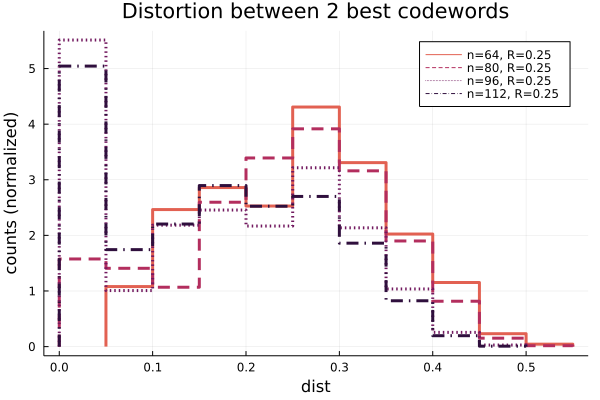

In [14]:
using ColorSchemes
cg = cgrad(:matter, length(ns)+2, categorical=true)
styles = [:solid, :dash, :dot, :dashdot, :dashdotdot]
h = plot()
for (i,n) in enumerate(ns)
    histogram!(h, dds[i], bins=10, normalize=:pdf, label="n=$n, R=$(float(R))", st=:stephist, 
        c=cg[i+2], lw=3, ls=styles[i])
end
plot(h, title="Distortion between 2 best codewords", xlabel="dist", ylabel="counts (normalized)")